# Projet 9 — Signaux de trading BTC–USDC : RandomForest vs Tiny Time Mixer (TTM)

Ce notebook suit le **plan prévisionnel** :  
- Données Binance (BTC–USDC)  
- Cible réaliste basée sur un ROI futur et frais  
- Baseline **RandomForestClassifier**  
- Modèle récent **Tiny Time Mixer (TTM)** (IBM TSFM) utilisé comme **forecaster**, puis conversion en signal de trading  
- Évaluation **ML + trading** (PnL, drawdown)

> Remarque : pour garder une comparaison simple et robuste, TTM est utilisé ici en *forecasting* du `Close` puis transformé en signal `Buy/No-trade` via un seuil de ROI.


## 0) Paramètres

In [123]:

# Paramètres globaux (à ajuster si besoin)
PAIR = "BTC/USDC"
TIMEFRAME = "1h"          # "15m" ou "1h"
START_YEAR = 2015
END_YEAR = 2025
CAPITAL_INIT = 1000
# Fenêtre et horizon
LOOKBACK = 512            # contexte pour TTM
HORIZON_STEPS = 24        # 24h si TIMEFRAME = 1h ; 16 si 4h en 15m ; etc.

# Trading/label
FEE_ROUNDTRIP = 0.002     # ~0.20% frais achat+vente (spot, simplifié)
THRESH = FEE_ROUNDTRIP    # seuil ROI minimal pour décider "Buy"

# Split temporel (chronologique)
TRAIN_RATIO = 0.80
VALID_RATIO = 0.10        # test = reste

RANDOM_SEED = 42


## 1) Installations & imports

In [4]:

# Si vous êtes sur Kaggle / Colab : décommentez selon l'environnement.

# !pip -q install ccxt ta scikit-learn matplotlib pandas numpy torch transformers accelerate

# --- TSFM (IBM) : on reproduit l'approche du notebook Kaggle TTM ---
# Le notebook Kaggle clone IBM/tsfm et importe tsfm_public.
# Ici on fait pareil pour être aligné.
import os, sys, subprocess, textwrap

TSFM_DIR = "tsfm"
# if not os.path.isdir(TSFM_DIR):
#     subprocess.check_call(["bash","-lc", f"git clone --depth 1 --branch v0.2.9 https://github.com/IBM/tsfm.git {TSFM_DIR}"])

# # Use sys.executable to ensure we install in the same Python environment as the notebook kernel
# subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "-e", TSFM_DIR])

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
)
from sklearn.ensemble import RandomForestClassifier

import ta

import torch
from transformers import set_seed

set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


/Users/nicolaspages/Formation OpenClassRooms Ingénieur IA/P09/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Chargement des données Binance (ccxt) + cache local

In [124]:

import ccxt
from datetime import datetime, timezone

def to_ms(dt: datetime) -> int:
    return int(dt.replace(tzinfo=timezone.utc).timestamp() * 1000)

def fetch_ohlcv_binance(pair: str, timeframe: str, start_year: int, end_year: int, limit=1000):
    ex = ccxt.binance({"enableRateLimit": True})
    all_rows = []
    since = to_ms(datetime(start_year, 1, 1))
    end_ms = to_ms(datetime(end_year, 12, 31, 23, 59))

    while since < end_ms:
        batch = ex.fetch_ohlcv(pair, timeframe=timeframe, since=since, limit=limit)
        if not batch:
            break
        all_rows.extend(batch)
        # avance d'un pas après le dernier timestamp
        since = batch[-1][0] + 1

        # sécurité anti-boucle
        if len(batch) < 10:
            break

    df = pd.DataFrame(all_rows, columns=["Timestamp", "Open", "High", "Low", "Close", "Volume"])
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="ms", utc=True)
    df = df.drop_duplicates(subset=["Timestamp"]).sort_values("Timestamp").reset_index(drop=True)
    return df

CACHE = f"btc_usdc_{TIMEFRAME}_{START_YEAR}_{END_YEAR}.csv"
if os.path.isfile(CACHE):
    df = pd.read_csv(CACHE, parse_dates=["Timestamp"])
    if df["Timestamp"].dt.tz is None:
        df["Timestamp"] = df["Timestamp"].dt.tz_localize("UTC")
else:
    df = fetch_ohlcv_binance(PAIR, TIMEFRAME, START_YEAR, END_YEAR)
    df.to_csv(CACHE, index=False)

df.head(), df.tail(), df.shape


(                  Timestamp     Open     High      Low    Close     Volume
 0 2018-12-15 03:00:00+00:00  3200.00  3312.32  3000.00  3225.97   2.374006
 1 2018-12-15 04:00:00+00:00  3225.97  3228.10  3205.58  3228.10   2.410518
 2 2018-12-15 05:00:00+00:00  3228.10  3228.10  3204.06  3222.87   3.514068
 3 2018-12-15 06:00:00+00:00  3225.68  3225.80  3199.87  3199.87   2.220411
 4 2018-12-15 07:00:00+00:00  3199.88  3220.15  3191.44  3205.42  46.164846,
                       Timestamp      Open      High       Low     Close  \
 57396 2025-12-16 06:00:00+00:00  86025.01  86621.12  86025.01  86504.27   
 57397 2025-12-16 07:00:00+00:00  86504.27  86609.46  85858.17  86009.67   
 57398 2025-12-16 08:00:00+00:00  86010.11  86394.11  85934.22  86275.01   
 57399 2025-12-16 09:00:00+00:00  86275.00  86422.62  86189.36  86347.67   
 57400 2025-12-16 10:00:00+00:00  86347.67  86500.00  86267.65  86434.43   
 
           Volume  
 57396  140.67154  
 57397  181.67359  
 57398   98.54300  
 5739

## 3) Préparation : nettoyage, features RF, labels

In [125]:

# Nettoyage basique
df = df.copy()
df = df.dropna().reset_index(drop=True)

# --- Features techniques pour RandomForest ---
# On calcule des indicateurs usuels (tendance, momentum, volatilité)
close = df["Close"]
high = df["High"]
low  = df["Low"]
vol  = df["Volume"]

# close = df["Close"].pct_change()
# high = df["High"].pct_change()
# low = df["Low"].pct_change()          
# vol = df["Volume"].pct_change()

df["logret_1"] = np.log(close).diff()
df["logret_5"] = np.log(close).diff(5)
df["logret_20"] = np.log(close).diff(20)

df["vol_20"] = df["logret_1"].rolling(20).std()
df["vol_50"] = df["logret_1"].rolling(50).std()

df["ma20"] = close.rolling(20).mean()
df["ma50"] = close.rolling(50).mean()
df["ema20"] = close.ewm(span=20, adjust=False).mean()
df["ema50"] = close.ewm(span=50, adjust=False).mean()

df["ma_diff"] = df["ma20"] - df["ma50"]
df["ema_diff"] = df["ema20"] - df["ema50"]

df["rsi14"] = ta.momentum.rsi(close, window=14)
macd = ta.trend.MACD(close)
df["macd"] = macd.macd()
df["macd_signal"] = macd.macd_signal()

df["atr14"] = ta.volatility.average_true_range(high, low, close, window=14) / close
df["adx14"] = ta.trend.adx(high, low, close, window=14)

df["hl_range"] = (high - low) / close
df["np_range"] = (high - low) / (close - df["Open"])
feature_cols = []

# --- Label : ROI futur à HORIZON_STEPS ---
df["future_close"] = df["Close"].shift(-HORIZON_STEPS)
df["roi_H"] = (df["future_close"] - df["Close"]) / df["Close"]
df["y"] = (df["roi_H"] > THRESH).astype(int)

# On retire les lignes avec NaNs (features + futur)
feature_cols = [
    #"Open","High","Low","Close","Volume",
    "logret_1","logret_5","logret_20",
    "vol_20","vol_50",
    "ma20","ma50","ema20","ema50","ma_diff","ema_diff",
    "rsi14","macd","macd_signal",
    "atr14","adx14","hl_range"
]
#feature_cols = ["Open","High","Low","Close","Volume"]
df_model = df.dropna(subset=feature_cols + ["y"]).reset_index(drop=True)

# Split temporel
n = len(df_model)
train_end = int(n * TRAIN_RATIO)
valid_end = int(n * (TRAIN_RATIO + VALID_RATIO))

train_df = df_model.iloc[:train_end].copy()
valid_df = df_model.iloc[train_end:valid_end].copy()
test_df  = df_model.iloc[valid_end:].copy()

(train_df.shape, valid_df.shape, test_df.shape, df_model["y"].value_counts(normalize=True))


((45880, 27),
 (5735, 27),
 (5736, 27),
 y
 0    0.523112
 1    0.476888
 Name: proportion, dtype: float64)

In [126]:
df_model.head(25)

,Timestamp,Open,High,Low,Close,Volume,logret_1,logret_5,logret_20,vol_20,...,rsi14,macd,macd_signal,atr14,adx14,hl_range,np_range,future_close,roi_H,y
0,2018-12-17 05:00:00+00:00,3207.23,3222.27,3202.15,3211.54,13.946837,0.001343,0.000480,-0.003019,0.004186,...,51.515549,-0.404208,0.753486,0.007298,10.709266,0.006265,4.668213,3475.64,0.082235,1
1,2018-12-17 06:00:00+00:00,3215.14,3225.00,3215.13,3215.13,7.947669,0.001117,0.007512,-0.003136,0.004185,...,52.794719,0.260119,0.654813,0.007068,10.564014,0.003070,-987.000000,3488.69,0.085085,1
2,2018-12-17 07:00:00+00:00,3216.75,3246.00,3214.68,3235.01,36.655374,0.006164,0.010850,-0.001378,0.004302,...,59.212173,2.363507,0.996552,0.007215,11.467919,0.009682,1.715225,3503.34,0.082946,1
3,2018-12-17 08:00:00+00:00,3233.41,3254.45,3232.54,3240.67,81.941718,0.001748,0.011068,0.002175,0.004300,...,60.844293,4.436037,1.684449,0.007171,12.661286,0.006761,3.017906,3446.76,0.063595,1
4,2018-12-17 09:00:00+00:00,3231.61,3245.24,3231.58,3234.79,6.783455,-0.001816,0.008556,0.004272,0.004222,...,58.237137,5.540200,2.455599,0.006972,13.697671,0.004223,4.295597,3443.39,0.064486,1
5,2018-12-17 10:00:00+00:00,3234.79,3246.34,3228.28,3233.91,7.181643,-0.000272,0.006941,0.010085,0.003957,...,57.837700,6.271950,3.218869,0.006875,14.403960,0.005585,-20.522727,3461.11,0.070256,1
6,2018-12-17 11:00:00+00:00,3235.62,3242.62,3229.74,3242.11,21.143248,0.002532,0.008357,0.011132,0.003978,...,60.552767,7.427914,4.060678,0.006651,15.059798,0.003973,1.984592,3476.76,0.072376,1
7,2018-12-17 12:00:00+00:00,3242.11,3393.97,3237.35,3385.65,211.584284,0.043322,0.045514,0.052963,0.010365,...,82.182404,19.699420,7.188427,0.009219,18.943225,0.046260,1.091124,3479.84,0.027820,1
8,2018-12-17 13:00:00+00:00,3394.00,3425.00,3372.00,3389.21,63.988158,0.001051,0.044817,0.057134,0.010284,...,82.439579,29.373341,11.625410,0.009668,22.804682,0.015638,-11.064718,3532.00,0.042131,1
9,2018-12-17 14:00:00+00:00,3391.00,3413.44,3384.54,3393.26,39.337003,0.001194,0.047827,0.057909,0.010276,...,82.744714,36.940962,16.688520,0.009575,26.390321,0.008517,12.787611,3567.59,0.051375,1


## 4) Baseline — RandomForestClassifier

In [127]:

X_train = train_df[feature_cols].values
y_train = train_df["y"].values

X_valid = valid_df[feature_cols].values
y_valid = valid_df["y"].values

X_test  = test_df[feature_cols].values
y_test  = test_df["y"].values

rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Probabilités pour AUC/PR-AUC
p_test = rf.predict_proba(X_test)[:,1]
pred_test = (p_test >= 0.5).astype(int)

print("RandomForest — Classification report (test):")
print(classification_report(y_test, pred_test, digits=4))

cm = confusion_matrix(y_test, pred_test)
print("Confusion matrix:\n", cm)

try:
    roc = roc_auc_score(y_test, p_test)
    print("ROC-AUC:", roc)
except Exception as e:
    print("ROC-AUC non calculable:", e)

prec, rec, _ = precision_recall_curve(y_test, p_test)
pr_auc = auc(rec, prec)
print("PR-AUC:", pr_auc)


RandomForest — Classification report (test):
              precision    recall  f1-score   support

           0     0.5498    0.9376    0.6932      3143
           1     0.4787    0.0694    0.1213      2593

    accuracy                         0.5452      5736
   macro avg     0.5143    0.5035    0.4072      5736
weighted avg     0.5177    0.5452    0.4346      5736

Confusion matrix:
 [[2947  196]
 [2413  180]]
ROC-AUC: 0.5150383463444927
PR-AUC: 0.47129744688085023


In [112]:
# Ajoute gridSearch cv sur tscv sur les hyperparamètres de RF

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Définition des hyperparamètres à explorer
param_grid = {
    'n_estimators': [800],
    'max_depth': [10, 20, 25],
    'min_samples_leaf': [10,50],
    'class_weight': ['balanced'],
    'random_state': [RANDOM_SEED]
}

# TimeSeries cross-validator 
tscv = TimeSeriesSplit(n_splits=5)

rf_model = RandomForestClassifier(n_jobs=-1)

# GridSearch avec CV temporel
grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc-auc',
    n_jobs=-1,
    verbose=2,
)

grid.fit(X_train, y_train)

print("Best RF params via GridSearchCV/TS-CV :")
print(grid.best_params_)
print("Best RF score:", grid.best_score_)

# Vous pouvez choisir le meilleur modèle ainsi:
best_rf = grid.best_estimator_

# Et l'utiliser comme à la place de rf :
# best_rf.fit(X_train, y_train)
# etc.



InvalidParameterError: The 'scoring' parameter of GridSearchCV must be a str among {'adjusted_mutual_info_score', 'mutual_info_score', 'recall_samples', 'precision_macro', 'rand_score', 'neg_brier_score', 'neg_mean_squared_error', 'f1_macro', 'neg_max_error', 'precision_micro', 'recall_weighted', 'normalized_mutual_info_score', 'jaccard_weighted', 'roc_auc_ovo', 'precision_weighted', 'roc_auc', 'neg_log_loss', 'matthews_corrcoef', 'explained_variance', 'roc_auc_ovr_weighted', 'recall_macro', 'completeness_score', 'd2_absolute_error_score', 'accuracy', 'jaccard_micro', 'neg_root_mean_squared_log_error', 'precision', 'jaccard_samples', 'jaccard', 'adjusted_rand_score', 'roc_auc_ovo_weighted', 'neg_root_mean_squared_error', 'positive_likelihood_ratio', 'fowlkes_mallows_score', 'neg_mean_gamma_deviance', 'roc_auc_ovr', 'd2_brier_score', 'f1_weighted', 'v_measure_score', 'f1', 'f1_samples', 'd2_log_loss_score', 'neg_mean_absolute_percentage_error', 'neg_negative_likelihood_ratio', 'precision_samples', 'average_precision', 'balanced_accuracy', 'neg_mean_absolute_error', 'f1_micro', 'r2', 'recall_micro', 'top_k_accuracy', 'homogeneity_score', 'neg_mean_squared_log_error', 'jaccard_macro', 'neg_median_absolute_error', 'recall', 'neg_mean_poisson_deviance'}, a callable, an instance of 'list', an instance of 'tuple', an instance of 'dict' or None. Got 'roc-auc' instead.

### Backtest simple (baseline RF)
Stratégie : **spot long-only**. Si prédiction=1 → être long sur l’horizon (ici simplifié pas-à-pas : position à 1 tant que le signal vaut 1). Frais appliqués lors des changements de position.

In [153]:
class Trader:
    def __init__(self, row: pd.Series, idx: int, idx_entry: int, signal: np.ndarray, capital: float, portfolio: float, position: float, qty: float, entry_price: float, exit_price: float, fee_roundtrip=0.002, pct_capital=1, debug=False, trade_list=[]):
        self.row = row
        self.idx = idx
        self.signal = signal
        self.fee_roundtrip = fee_roundtrip
        self.pct_capital = pct_capital
        self.capital = capital    
        self.portfolio = portfolio
        self.position = position
        self.qty = qty
        self.entry_price = entry_price
        self.exit_price = exit_price
        self.debug = debug
        self.idx_entry = idx_entry
        self.trade_list = trade_list
        self.timestamp_entry = None
        self.max_drawdown_pct = 0


    def _buy(self):
        self.qty = self.pct_capital * self.capital / self.row["Close"]
        position_value = self.qty * self.row["Close"]
        self.position = position_value  # Montant investi dans la position
        self.entry_price = self.row["Close"]
        buy_fees = self.fee_roundtrip * position_value / 2
        self.capital -= (position_value + buy_fees)
        self.portfolio = position_value  # Portfolio = valeur de la position
        self.idx_entry = self.idx
        self.timestamp_entry = self.row["Timestamp"]
        if self.debug:
            print(f"Idx: {self.idx} / Buy: {self.qty:.8f} @ {self.entry_price:.2f}")
        return True

    def _sell(self):
        sell_value = self.qty * self.row["Close"]
        sell_fees = self.fee_roundtrip * sell_value / 2
        PnL = self.qty * (self.row["Close"] - self.entry_price)
        PnL_net = PnL - sell_fees
        capital_before_sell = self.portfolio+self.capital
        self.capital += sell_value - sell_fees
        self.position = 0  # Plus de position ouverte
        self.exit_price = self.row["Close"]
        self.portfolio = 0  # Portfolio vide après vente
        self.max_drawdown_pct = (PnL/capital_before_sell)*100
        self.trade_list.append({
            "idx": self.idx,
            "idx_entry": self.idx_entry,
            "Timestamp": self.row["Timestamp"],
            "Timestamp_entry": self.timestamp_entry,
            "qty": self.qty,
            "entry_price": self.entry_price,
            "exit_price": self.exit_price,
            "PnL": PnL,
            "PnL_net": PnL_net,
            "Capital": self.capital,
            "MaxDrawDown": self.max_drawdown_pct,
        })

        if self.debug:
            print(f"Idx: {self.idx} / Sell: {self.qty:.8f} @ {self.exit_price:.2f}")
            print(f"PnL: {PnL:.2f}")
            print(f"PnL net (après frais): {PnL_net:.2f}")
            print(f"Portfolio: {self.portfolio:.2f}")
            print(f"Capital: {self.capital:.2f}")
        return True

    def run(self):
        # Conversion du signal en int (gère les cas numpy array et scalar)
        sig = int(self.signal) if isinstance(self.signal, (np.ndarray, np.generic)) else int(self.signal)
        
        # Mise à jour du portfolio si position ouverte (valeur actuelle de la position)
        if self.position > 0:
            self.portfolio = self.qty * self.row["Close"]
        
        if self.debug:
            print(f"Idx: {self.idx} / Signal: {sig} / Position: {self.position:.2f} / Portfolio: {self.portfolio:.2f}")
        
        # Achat : signal=1 et pas de position ouverte
        if sig == 1 and self.position == 0:
            self._buy()
        # Vente : signal=0 et position ouverte (on vend dès que le signal passe à 0)
        elif sig == 0 and self.position > 0 and self.idx >= self.idx_entry + HORIZON_STEPS:
            self._sell()
        
        return self.portfolio, self.capital, self.position, self.qty, self.entry_price, self.exit_price, self.trade_list     


class Backtest:
    def __init__(self, df_bt: pd.DataFrame, signal: np.ndarray, fee_roundtrip=0.002, pct_capital=1, capital_init=1000, debug=False):
        self.df_bt = df_bt
        self.signal = signal
        self.fee_roundtrip = fee_roundtrip
        self.pct_capital = pct_capital
        self.capital_init = capital_init  # Sauvegarder le capital initial
        self.capital = capital_init
        self.position = 0
        self.qty = 0
        self.entry_price = 0
        self.exit_price = 0
        self.portfolio = 0
        self.debug = debug
        self.idx_entry = 0
        self.trade_list = []
        self.max_drawdown_pct = 0
        self.run()
        self.print_stats()

    def run(self):
        trader = Trader([], 0, 0, 0, self.capital, self.portfolio, self.position, self.qty, self.entry_price, self.exit_price, self.fee_roundtrip, self.pct_capital, debug=self.debug, trade_list=self.trade_list)
        last_idx = None
        for i, row in self.df_bt.iterrows():
            trader.row = row
            trader.idx = i
            trader.signal = self.signal[i]
            trader.run()
            self.portfolio = trader.portfolio
            self.capital = trader.capital   
            self.position = trader.position
            self.qty = trader.qty
            self.entry_price = trader.entry_price
            self.exit_price = trader.exit_price
            self.idx_entry = trader.idx_entry
            self.timestamp_entry = trader.timestamp_entry
            last_idx = i

        # Clôture forcée si position ouverte en fin de backtest
        if self.position > 0 and last_idx is not None:
            last_row = self.df_bt.iloc[last_idx]
            sell_value = self.qty * last_row["Close"]
            sell_fees = self.fee_roundtrip * sell_value / 2
            PnL = self.qty * (last_row["Close"] - self.entry_price)
            PnL_net = PnL - sell_fees
            self.capital += sell_value - sell_fees
            self.portfolio = 0
            self.position = 0
            self.trade_list.append({
                "idx": last_idx,
                "idx_entry": self.idx_entry,
                "Timestamp": last_row["Timestamp"],
                "Timestamp_entry": self.timestamp_entry,
                "qty": self.qty,
                "entry_price": self.entry_price,
                "exit_price": last_row["Close"],
                "PnL": PnL,
                "PnL_net": PnL_net,
                "Capital": self.capital,
                "MaxDrawDown": self.max_drawdown_pct,
            })
            self.qty = 0
            self.entry_price = 0
            self.exit_price = 0
        
        days = (self.df_bt.iloc[-1]["Timestamp"] - self.df_bt.iloc[0]["Timestamp"]).days
        if days <= 0:
            days = 1  # Avoid division by zero
        self.days = days
        self.PnL = self.capital - self.capital_init
        self.ROI_pct = self.PnL / self.capital_init *100
        self.ROI_day_pct = self.PnL / self.capital_init / days * 100
        # Calculate annualized ROI: convert ROI_pct from percentage to decimal first
        roi_decimal = self.ROI_pct / 100
        if roi_decimal <= -1:
            # If we lost more than 100%, return -100%
            self.ROI_annualized_pct = -100.0
        else:
            self.ROI_annualized_pct = ((1 + roi_decimal) ** (365.0 / days) - 1) * 100
        self.df_trades = pd.DataFrame(self.trade_list)
        self.win_rates = self.df_trades["PnL"].apply(lambda x: x > 0).mean()*100
        self.nb_trades = len(self.df_trades)
        self.nb_trades_by_day = self.nb_trades / days
        self.max_drawdown_pct = self.df_trades["MaxDrawDown"].max()
        return self.portfolio, self.capital, self.position, self.qty, self.entry_price, self.exit_price, self.trade_list
    
    def print_stats(self):
        print(f"Days: {self.days}")
        print(f"Portfolio: {self.portfolio}")
        print(f"Capital: {self.capital}")
        print(f"PnL: {self.capital - CAPITAL_INIT}")
        print(f"Position: {self.position}")
        print(f"ROI: {self.ROI_pct:.2f}%")
        print(f"ROI annualized: {self.ROI_annualized_pct:.2f}%")
        print(f"ROI day: {self.ROI_day_pct:.2f}%")
        print(f"Win rate: {self.win_rates:.2f}%")
        print(f"Nb trades: {self.nb_trades}")
        print(f"Nb trades par jour: {self.nb_trades_by_day:.2f}")
        print(f"Max DrawDown: {self.max_drawdown_pct:.2f}%")


In [154]:
backtester = Backtest(test_df.reset_index(), pred_test, fee_roundtrip=0, pct_capital=1, capital_init=CAPITAL_INIT, debug=False)


Days: 238
Portfolio: 0
Capital: 851.0188765186468
PnL: -148.98112348135317
Position: 0
ROI: -14.90%
ROI annualized: -21.92%
ROI day: -0.06%
Win rate: 40.62%
Nb trades: 32
Nb trades par jour: 0.13
Max DrawDown: 3.88%


In [155]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


def plot_backtest(backtester):
    # On suppose que trades_df == backtester.df_trades déjà généré avec l'algo ci-dessus
    trades_df = backtester.df_trades

    # Pour le graphique, récupérer le temps et close price
    df_curves = backtester.df_bt.reset_index(drop=True)
    df_curves["Timestamp_entry"] = df_curves["Timestamp"]
    df_curves = pd.merge(df_curves, trades_df[["Timestamp", "exit_price","Capital"]], on="Timestamp", how="left")
    df_curves = pd.merge(df_curves, trades_df[["Timestamp_entry", "entry_price"]], on="Timestamp_entry", how="left")
    df_curves["Capital"] = df_curves["Capital"].fillna(method="ffill").fillna(backtester.capital_init)

    timestamps = df_curves["Timestamp"]
    close_prices = df_curves["Close"]
    capital_curve = df_curves["Capital"]
    buy_time = df_curves["Timestamp_entry"]
    buy_price = df_curves["entry_price"]
    sell_time = df_curves["Timestamp"]
    sell_price = df_curves["exit_price"]

    # Créer un subplot avec 2 graphiques (prix en haut, capital en bas)
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=('Cours Close avec signaux Buy/Sell', 'Évolution du Capital'),
        row_heights=[0.6, 0.4]
    )

    # Graphique 1 : Prix avec signaux
    fig.add_trace(
        go.Scatter(
            x=timestamps,
            y=close_prices,
            mode='lines',
            name='Close',
            line=dict(color='blue')
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=buy_time,
            y=buy_price,
            mode='markers',
            marker=dict(color='green', symbol='triangle-up', size=10),
            name='Buy'
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=sell_time,
            y=sell_price,
            mode='markers',
            marker=dict(color='red', symbol='triangle-down', size=10),
            name='Sell'
        ),
        row=1, col=1
    )

    # Graphique 2 : Capital
    fig.add_trace(
        go.Scatter(
            x=timestamps,
            y=capital_curve,
            mode='lines',
            name='Capital',
            line=dict(color='purple', width=2)
        ),
        row=2, col=1
    )

    # Ligne de référence pour le capital initial
    fig.add_hline(
        y=backtester.capital_init,
        line_dash="dash",
        line_color="gray",
        annotation_text=f"Capital initial: {backtester.capital_init:.2f}",
        row=2, col=1
    )

    fig.update_layout(
        title='Cours Close avec signaux Buy/Sell et Évolution du Capital',
        height=800,
        width=1200,
        showlegend=True,
        legend=dict(x=0, y=1)
    )

    fig.update_xaxes(title_text="Timestamp", row=2, col=1)
    fig.update_yaxes(title_text="Prix", row=1, col=1)
    fig.update_yaxes(title_text="Capital", row=2, col=1)

    fig.show()

In [149]:
plot_backtest(backtester)

/var/folders/ww/n5qp3lj11bq3jsl9nv331j2m0000gn/T/ipykernel_31092/3141848499.py:14: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



## 4bis Modèle récent — TabNetClassifier (remplacement plug & play de RandomForest)


In [157]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import StandardScaler

# Scaling (fit sur train uniquement) - CRITIQUE pour TabNet
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

y_train_tab = y_train
y_valid_tab = y_valid
y_test_tab  = y_test

# Retour aux hyperparamètres qui fonctionnaient mieux (TEST 1 était pire)
tabnet = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=RANDOM_SEED,
    verbose=10
)

tabnet.fit(
    X_train_s, y_train_tab,
    eval_set=[(X_valid_s, y_valid_tab)],
    eval_name=["valid"],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0,
    drop_last=False
)

# Évaluation classification (test)
p_test_tab = tabnet.predict_proba(X_test_s)[:, 1]
pred_test_tab = (p_test_tab >= 0.5).astype(int)

print("\n" + "="*60)
print("TabNet - Classification report (test)")
print("="*60)
print(classification_report(y_test_tab, pred_test_tab, digits=4))

cm_tab = confusion_matrix(y_test_tab, pred_test_tab)
print("Confusion matrix:\n", cm_tab)

try:
    roc_tab = roc_auc_score(y_test_tab, p_test_tab)
    print("ROC-AUC:", roc_tab)
except Exception as e:
    print("ROC-AUC non calculable:", e)

prec_tab, rec_tab, _ = precision_recall_curve(y_test_tab, p_test_tab)
pr_auc_tab = auc(rec_tab, prec_tab)
print("PR-AUC:", pr_auc_tab)

/Users/nicolaspages/Formation OpenClassRooms Ingénieur IA/P09/.venv/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning:

Device used : cpu



epoch 0  | loss: 0.90809 | valid_auc: 0.51463 |  0:00:06s


KeyboardInterrupt: 

In [121]:
#Cellule — Backtest TabNet (même backtest que RF)
# Backtest TabNet — on réutilise EXACTEMENT la même classe Backtest que pour RF
capital_init = 1000

backtester_tabnet = Backtest(
    test_df.reset_index(drop=True),   # même df que RF
    pred_test_tab,                    # signaux TabNet (0/1)
    fee_roundtrip=FEE_ROUNDTRIP,
    pct_capital=0.1,                  # même allocation que ton RF (si c'est ton choix)
    capital_init=capital_init,
    debug=False
)

backtester_tabnet.run()

print(f"TabNet | Capital final: {backtester_tabnet.capital:.2f}")
print(f"TabNet | PnL net: {backtester_tabnet.capital - capital_init:.2f}")
print(f"TabNet | Position: {backtester_tabnet.position}")
print(f"TabNet | Qty: {backtester_tabnet.qty}")

#Cellule — Tableau comparaison RF vs TabNet (version simple, basée sur capital/PnL)
capital_init = 1000

# RF (si tu utilises déjà `backtester` pour RF)
pnl_rf = backtester.capital - capital_init
pnl_tabnet = backtester_tabnet.capital - capital_init

results_bt = pd.DataFrame([
    {"Model": "RandomForest", "CapitalFinal": backtester.capital, "PnL": pnl_rf},
    {"Model": "TabNet", "CapitalFinal": backtester_tabnet.capital, "PnL": pnl_tabnet},
])

results_bt

TabNet | Capital final: 935.77
TabNet | PnL net: -64.23
TabNet | Position: 0
TabNet | Qty: 0


,Model,CapitalFinal,PnL
0,RandomForest,995.969022,-4.030978
1,TabNet,935.771355,-64.228645


## 5) Modèle récent — Tiny Time Mixer (TTM) : forecasting → signal

On reproduit l’approche du notebook Kaggle **Tiny Time Mixer** (TSFM) :  
- on prépare le dataset pour forecasting (cible = `Close`)  
- on fine-tune léger TTM (optionnel, mais recommandé)  
- on produit une prévision à `HORIZON_STEPS` et on convertit en signal :  
`Buy` si ROI prédit > seuil (frais).


In [65]:
# Ensure tsfm_public is installed in the current Python environment
import sys
import subprocess
import os

try:
    import tsfm_public
    print(f"✓ tsfm_public is installed (version: {tsfm_public.__version__})")
except ImportError:
    print("Installing tsfm_public in current Python environment...")
    TSFM_DIR = "tsfm"
    if not os.path.isdir(TSFM_DIR):
        subprocess.check_call(["bash","-lc", f"git clone --depth 1 --branch v0.2.9 https://github.com/IBM/tsfm.git {TSFM_DIR}"])
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "-e", TSFM_DIR])
    print("✓ Installation complete. Please restart the kernel and re-run this cell.")



✓ tsfm_public is installed (version: 0.2.10.dev0+gf856e5bfc.d20251214)


In [36]:
# Import from submodules directly (following official notebook pattern)
# Import from specific modules to avoid circular import issues
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor, get_datasets
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline

# Import transformers utilities
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

print("✓ Imports successful")


✓ Imports successful


### 5.1 Préparation des données pour TTM

In [37]:

# Pour rester simple : TTM voit Open/High/Low comme observables, Close comme target
timestamp_column = "Timestamp"
target_columns = ["Close"]
observable_columns = ["Open","High","Low","Volume"]

# On prend df (brut) mais on se limite à la zone où le futur existe (sinon label NaN)
df_ttm = df.dropna(subset=["Open","High","Low","Close","Volume"]).copy()

# Préprocesseur TSFM (semblable au notebook Kaggle)
# Note: context_length et prediction_length sont passés au preprocessor
# Le modèle pré-entraîné utilise prediction_length=96, on doit l'utiliser ici aussi
# On utilisera ensuite seulement les HORIZON_STEPS premiers pas pour le signal de trading
tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq=TIMEFRAME,
    context_length=LOOKBACK,
    prediction_length=96  # Doit correspondre au modèle pré-entraîné
)

# Split indices sur df_ttm (chronologique)
data_length = len(df_ttm)
train_start_index = 0
train_end_index = round(data_length * TRAIN_RATIO)

eval_start_index = train_end_index - LOOKBACK
eval_end_index   = round(data_length * (TRAIN_RATIO + VALID_RATIO))

test_start_index = eval_end_index - LOOKBACK
test_end_index   = data_length

split_config = {
    "train": [train_start_index, train_end_index],
    "valid": [eval_start_index, eval_end_index],
    "test":  [test_start_index, test_end_index],
}

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp,
    df_ttm,
    split_config=split_config
)

len(train_dataset), len(valid_dataset), len(test_dataset)


(30845, 4349, 4348)

### 5.2 Chargement du modèle TTM

In [38]:

# Checkpoint public utilisé par TSFM (le notebook Kaggle utilise TinyTimeMixerForPrediction)
# Remarque : selon l'environnement, le téléchargement HF peut prendre du temps.
# Le checkpoint est entraîné avec prediction_length=96, on doit l'utiliser tel quel
# On utilisera ensuite seulement les HORIZON_STEPS premiers pas de la prédiction
model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r2",  # checkpoint TTM (prediction_length=96)
    context_length=LOOKBACK,
    prediction_length=96  # Le checkpoint utilise 96, on doit respecter cette valeur
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"✓ Modèle chargé sur {device}")
print(f"  - context_length: {model.config.context_length}")
print(f"  - prediction_length: {model.config.prediction_length}")
print(f"  - On utilisera les {HORIZON_STEPS} premiers pas de la prédiction")


✓ Modèle chargé sur cpu
  - context_length: 512
  - prediction_length: 96
  - On utilisera les 24 premiers pas de la prédiction


### 5.3 Fine-tuning léger (optionnel mais recommandé)

In [ ]:

# Entraînement léger sur CPU possible mais plus lent.
# Vous pouvez passer SKIP_FINETUNE=True pour tester rapidement en zero-shot.

SKIP_FINETUNE = False

if not SKIP_FINETUNE:
    # Arguments d'entraînement
    training_args = TrainingArguments(
        output_dir="ttm_finetune_out",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        logging_steps=50,
        seed=RANDOM_SEED,
        fp16=torch.cuda.is_available(),
        report_to="none"
    )

    optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)
    steps_per_epoch = max(1, len(train_dataset) // training_args.per_device_train_batch_size)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=training_args.learning_rate,
        steps_per_epoch=steps_per_epoch,
        epochs=training_args.num_train_epochs,
    )

    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        callbacks=[early_stopping],
        optimizers=(optimizer, scheduler)
    )

    trainer.train()


/Users/nicolaspages/Formation OpenClassRooms Ingénieur IA/P09/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,3521865.600000,7522069.000000


/Users/nicolaspages/Formation OpenClassRooms Ingénieur IA/P09/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


### 5.4 Prédiction sur test → signal Buy/No-trade

In [ ]:

forecast_pipeline = TimeSeriesForecastingPipeline(
    model=model,
    device=device,
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq=TIMEFRAME
)

# Prévisions : on obtient une table avec Close réel et Close_prediction (format pipeline TSFM)
ttm_forecast = forecast_pipeline(tsp.preprocess(df_ttm.iloc[test_start_index:test_end_index].copy()))
ttm_forecast.head(), ttm_forecast.tail()


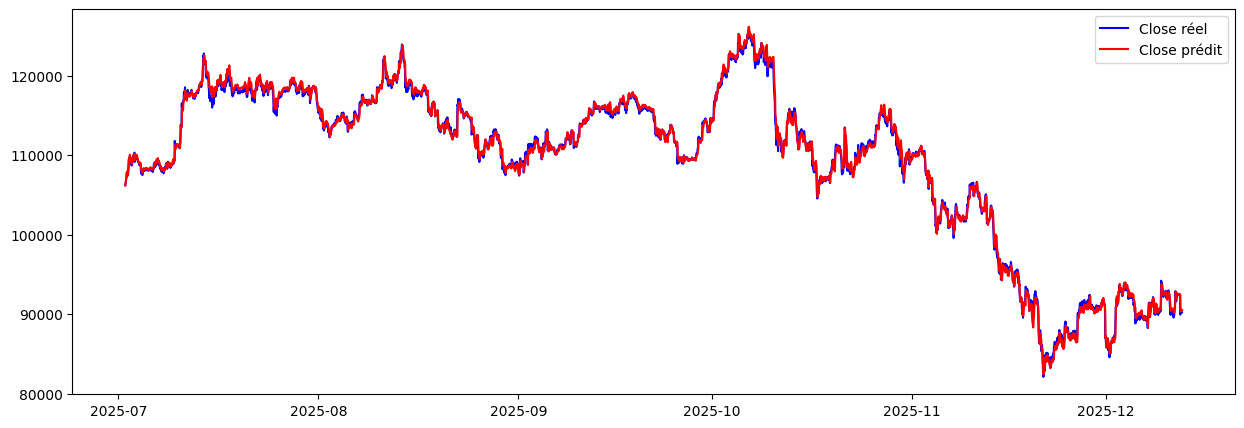

In [108]:
# Traçage de la courbe Close réel et Close_prediction, gestion des séquences éventuelles (list/array)
def extract_scalar_for_plot(x, index=0):
    try:
        if isinstance(x, (list, tuple, np.ndarray)):
            if len(x) > index:
                return float(x[index])
            elif len(x) > 0:
                return float(x[0])
            else:
                return np.nan
        else:
            return float(x)
    except Exception:
        return np.nan

# Extraction sécurisée des valeurs pour l'affichage
close_y = [extract_scalar_for_plot(x) for x in ttm_forecast["Close"]]
close_pred_y = [extract_scalar_for_plot(x) for x in ttm_forecast["Close_prediction"]]
timestamps = ttm_forecast["Timestamp"]

plt.figure(figsize=(15, 5))
plt.plot(timestamps, close_y, label="Close réel", color="blue")
plt.plot(timestamps, close_pred_y, label="Close prédit", color="red")
plt.legend()
plt.show()


In [54]:

# On reconstruit un signal à partir du ROI prédit à horizon HORIZON_STEPS :
# ROI_pred = (Close_pred(t+H) - Close(t)) / Close(t)
# Le modèle prédit 96 pas, mais on utilise seulement le pas HORIZON_STEPS (index HORIZON_STEPS-1)

ttm_df = ttm_forecast.copy()

# Fonction helper pour extraire une valeur scalaire d'une structure (scalaire, liste, array)
def extract_scalar(x, index=0):
    """Extrait une valeur scalaire d'une structure, en prenant l'élément à l'index donné."""
    if isinstance(x, (list, tuple)):
        if len(x) > index:
            return float(x[index])
        elif len(x) > 0:
            return float(x[0])  # Fallback au premier élément
        else:
            return np.nan
    elif isinstance(x, np.ndarray):
        if len(x) > index:
            return float(x[index])
        elif len(x) > 0:
            return float(x[0])
        else:
            return np.nan
    else:
        # Si c'est déjà un scalaire
        try:
            return float(x)
        except (TypeError, ValueError):
            return np.nan

# Extraction de Close (valeur actuelle) - on prend le premier élément si c'est une séquence
close_col = ttm_df["Close"]
if np.issubdtype(close_col.dtype, np.number):
    close_now = close_col.values.astype(float)
else:
    close_now = np.array([extract_scalar(x, index=0) for x in close_col.values], dtype=float)

# Gestion de différents formats de prédiction
if "Close_prediction" in ttm_df.columns:
    pred_col = ttm_df["Close_prediction"]
    
    # Cas 1 : Close_prediction est un scalaire (déjà extrait)
    if np.issubdtype(pred_col.dtype, np.number):
        close_pred = pred_col.values.astype(float)
    # Cas 2 : Close_prediction contient une séquence (array/list)
    else:
        # Extraire le pas HORIZON_STEPS (index HORIZON_STEPS-1) de chaque prédiction
        close_pred = np.array([extract_scalar(x, index=HORIZON_STEPS - 1) for x in pred_col.values], dtype=float)
else:
    raise ValueError("Colonne 'Close_prediction' introuvable dans ttm_forecast")

# Vérification des dimensions
if len(close_pred) != len(close_now):
    raise ValueError(f"Dimensions incompatibles: close_pred={len(close_pred)}, close_now={len(close_now)}")

# Calcul du ROI prédit
roi_pred = (close_pred - close_now) / close_now

ttm_signal = (roi_pred > THRESH).astype(int)

# Alignement avec test_df : on va évaluer sur une fenêtre comparable en timestamps
# On mappe par Timestamp
# Utiliser les valeurs extraites (float) au lieu de la colonne originale (peut être object)
# Garder Timestamp comme Series pour pouvoir manipuler le timezone
ttm_eval = pd.DataFrame({
    "Timestamp": ttm_df["Timestamp"],  # Garder comme Series, pas .values
    "Close": close_now,  # Utiliser les valeurs extraites (float)
    "signal": ttm_signal
})

# test_df correspond à df_model (après features), donc pas même index.
# On évalue sur les timestamps communs.
test_eval = test_df[["Timestamp","Close","y"]].copy()

# Normaliser les timezones pour permettre le merge
# Convertir les deux en timezone-naive pour éviter les problèmes de merge
if test_eval["Timestamp"].dtype.tz is not None:
    test_eval["Timestamp"] = test_eval["Timestamp"].dt.tz_localize(None)
if ttm_eval["Timestamp"].dtype.tz is not None:
    ttm_eval["Timestamp"] = ttm_eval["Timestamp"].dt.tz_localize(None)

# Merge sur Timestamp uniquement (identifiant unique, évite les problèmes de précision float)
merged = test_eval.merge(ttm_eval[["Timestamp", "signal"]], on="Timestamp", how="inner")
print("Taille evaluation commune:", merged.shape)

y_true_ttm = merged["y"].values
y_pred_ttm = merged["signal"].values

print("TTM (forecast→signal) — Classification report (test, aligned):")
print(classification_report(y_true_ttm, y_pred_ttm, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true_ttm, y_pred_ttm))

# Pour AUC/PR-AUC, on peut utiliser roi_pred comme score (monotone du signal)
# On reconstitue le score correspondant à merged
# Utiliser les Timestamp de ttm_eval pour la cohérence
score_map = pd.Series(roi_pred, index=ttm_eval["Timestamp"]).to_dict()
scores = np.array([score_map.get(t, np.nan) for t in merged["Timestamp"]], dtype=float)
# Filtrer les NaN si nécessaire
valid_mask = ~np.isnan(scores)
if not valid_mask.all():
    print(f"Attention: {np.sum(~valid_mask)} scores NaN, ils seront ignorés pour AUC")

# Filtrer les NaN avant les calculs AUC
if not valid_mask.all():
    y_true_ttm_clean = y_true_ttm[valid_mask]
    scores_clean = scores[valid_mask]
else:
    y_true_ttm_clean = y_true_ttm
    scores_clean = scores

try:
    roc = roc_auc_score(y_true_ttm_clean, scores_clean)
    print("ROC-AUC:", roc)
except Exception as e:
    print("ROC-AUC non calculable:", e)

try:
    prec, rec, _ = precision_recall_curve(y_true_ttm_clean, scores_clean)
    pr_auc = auc(rec, prec)
    print("PR-AUC:", pr_auc)
except Exception as e:
    print("PR-AUC non calculable:", e)


Taille evaluation commune: (3927, 4)
TTM (forecast→signal) — Classification report (test, aligned):
              precision    recall  f1-score   support

           0     0.5292    0.4630    0.4939      2151
           1     0.4352    0.5011    0.4658      1776

    accuracy                         0.4803      3927
   macro avg     0.4822    0.4821    0.4799      3927
weighted avg     0.4867    0.4803    0.4812      3927

Confusion matrix:
 [[ 996 1155]
 [ 886  890]]
Attention: 1 scores NaN, ils seront ignorés pour AUC
ROC-AUC non calculable: Input contains NaN.


ValueError: Input contains NaN.

### Backtest simple (TTM)

In [55]:

bt_ttm = backtest_long_only(merged.rename(columns={"Close":"Close"}), y_pred_ttm, fee_roundtrip=FEE_ROUNDTRIP)

bt_ttm["total_return"], bt_ttm["max_drawdown"], bt_ttm["sharpe_simple"]


NameError: name 'backtest_long_only' is not defined

## 6) Comparaison synthétique + courbes d'equity

In [56]:

results = pd.DataFrame([
    {"Model":"RandomForest", "TotalReturn": bt_rf["total_return"], "MaxDD": bt_rf["max_drawdown"], "SharpeSimple": bt_rf["sharpe_simple"]},
    {"Model":"TTM (forecast→signal)", "TotalReturn": bt_ttm["total_return"], "MaxDD": bt_ttm["max_drawdown"], "SharpeSimple": bt_ttm["sharpe_simple"]},
])

results


NameError: name 'bt_rf' is not defined

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(bt_rf["equity"], label="RandomForest")
plt.plot(bt_ttm["equity"], label="TTM (forecast→signal)")
plt.title("Equity curve (test)")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Notes pour le dashboard Streamlit (à implémenter ensuite)
- Charger les derniers points OHLCV
- Calculer features RF et prédiction RF
- Exécuter TTM pipeline sur la fenêtre récente et générer signal
- Afficher signal + courbe prix + métriques